In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.mie import mie

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
MIE_WEIGHTS_PATH = os.path.join(ROOT_DIR, "logs/mie20190731T1317/mask_rcnn_mie_0030.h5")  # TODO: update this path

Using TensorFlow backend.
W0801 13:13:12.239534 140543679801152 deprecation_wrapper.py:119] From /home/lattice/Dev/Mask_RCNN/samples/mie/mie.py:40: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0801 13:13:12.240070 140543679801152 deprecation_wrapper.py:119] From /home/lattice/Dev/Mask_RCNN/samples/mie/mie.py:43: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
config = mie.MieConfig()
MIE_DIR = os.path.join(ROOT_DIR, "samples/mie/test_1/datasets")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Load validation dataset
dataset = mie.MieDataset()
dataset.load_mie(MIE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 15
Classes: ['BG', 'mie']


In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0801 13:13:13.041162 140543679801152 deprecation_wrapper.py:119] From /home/lattice/Dev/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 13:13:13.043929 140543679801152 deprecation_wrapper.py:119] From /home/lattice/Dev/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 13:13:13.045984 140543679801152 deprecation_wrapper.py:119] From /home/lattice/Dev/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 13:13:13.062067 140543679801152 deprecation_wrapper.py:119] From /home/lattice/Dev/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.f

In [8]:
# Set path to mie weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = MIE_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/lattice/Dev/Mask_RCNN/logs/mie20190731T1317/mask_rcnn_mie_0030.h5
Re-starting from epoch 30


image ID: mie.mie1337.jpg (13) /home/lattice/Dev/Mask_RCNN/samples/mie/test_1/datasets/val/mie1337.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  389.00000  max:  709.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


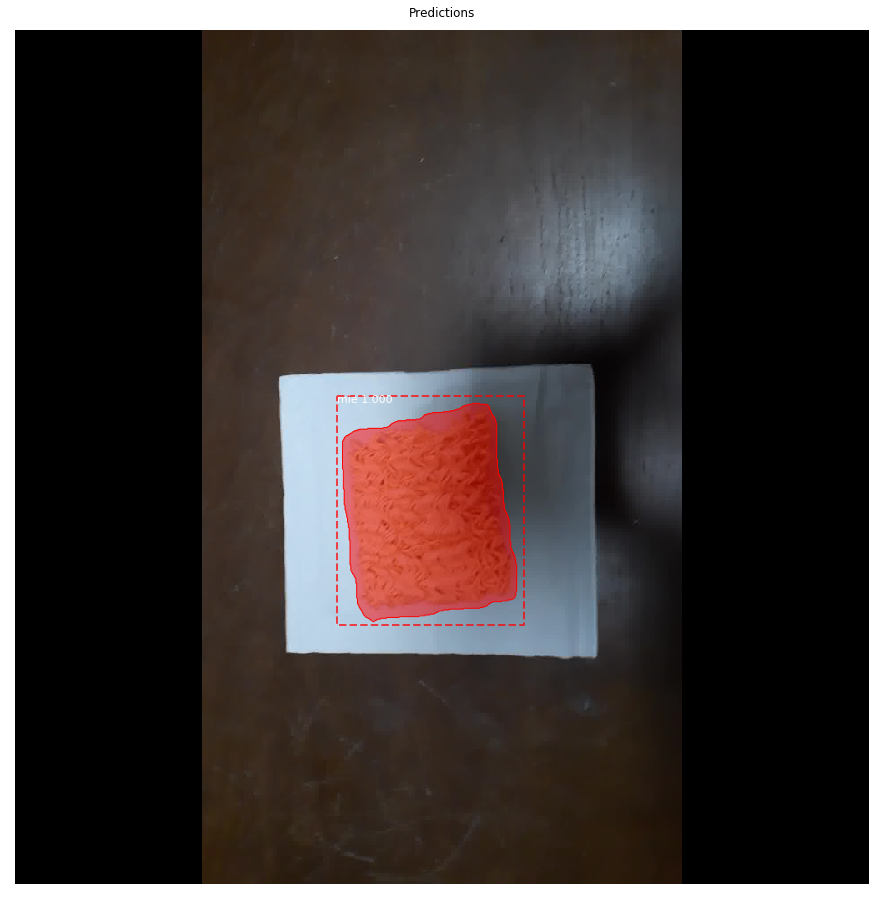

In [9]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

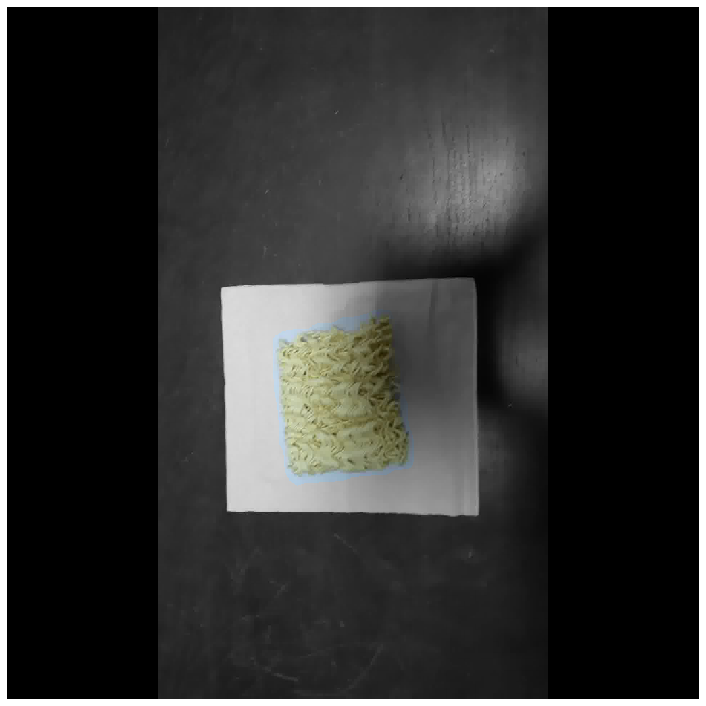

In [10]:
splash = mie.color_splash(image, r['masks'])
display_images([splash], cols=1)